In [1]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class SelectItem(BaseEstimator, TransformerMixin):
    
    def __init__(self, features=[]):
        self._features = features
    
    def fit(self, X, y=None):
        if len(self._features)==0:
            self._features = X.columns
        return self
        
    def transform(self, X, y=None):
        return X.loc[:, self._features].values
    
class SinCos(BaseEstimator, TransformerMixin):
    
    def __init__(self, dosin=True, docos=True):
        self._dosin = dosin
        self._docos = docos
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        tmp=[]
        for j in X.T:
            if self._dosin:
                tmp.append( np.sin(j) )
            if self._docos:
                tmp.append( np.cos(j) )
        return np.vstack(tmp).T
                
class Encoding(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop='first', sparse=False, handle_unknown = 'ignore'):
        self._drop = drop
        self._sparse = sparse
        self._err = handle_unknown
        self._fitted = []
    
    def fit(self, X, y=None):
        for j in X.T:
            encoder = OneHotEncoder(sparse=self._sparse, handle_unknown = self._err)
            encoder.fit(j.reshape(-1,1))
            self._fitted.append(encoder)
            
        return self
    
    def transform(self, X, y=None):
        tmp=[]
        for i, j in enumerate(X.T):
            encoder = self._fitted[i]
            tmp.append( encoder.transform(j.reshape(-1,1)) )
        return np.hstack(tmp)
        

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
df = pd.concat([pd.DataFrame(data.target, columns=['target']),pd.DataFrame(data.data, columns=data.feature_names)], axis=1)

In [3]:
df.head()

,target,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

pipe_sincos = Pipeline([('selsincos', SelectItem(features=['sepal width (cm)','petal length (cm)','petal width (cm)'])),
              ('sincos',  SinCos(dosin=True, docos=True) )
             ])

pipe_dum = Pipeline([('selcat', SelectItem(features=['target'])),
              ('categ',  Encoding() )
             ])
pipe_union = FeatureUnion([('etape1' ,pipe_sincos), ('etape2', pipe_dum)])

In [5]:
pipe_union.fit(df)
resultat = pipe_union.transform(df)

In [6]:
pd.DataFrame(resultat).head(2)

,0,1,2,3,4,5,6,7,8
0,-0.350783,-0.936457,0.98545,0.169967,0.198669,0.980067,1.0,0.0,0.0
1,0.141120,-0.989992,0.98545,0.169967,0.198669,0.980067,1.0,0.0,0.0


KMeans class

In [7]:
from scipy.spatial import distance_matrix
from numpy.linalg import norm

class KmeansCluster(BaseEstimator, TransformerMixin):
    
    def __init__(self, center, max_iter=100):
        self._center = center
        self._max_iter = max_iter
        self._gravity = None
        
    def fit(self, X, y=None):
        #first iteration
        first_iter_ind = np.random.choice(range(len(X)), self._center)
        gravity = X[first_iter_ind, :]
        dist_to_cluster = distance_matrix(X, gravity)
        old_label = np.argmin(dist_to_cluster, axis=1)
        new_label = np.empty(len(X))
        
        it=0
        while (it<self._max_iter) & ((new_label != old_label).sum() > 0):
            if it>0:
                old_label = new_label
            gravity = self.actualiser_gravity(old_label, X)
            
            dist_to_cluster = distance_matrix(X, gravity)
            new_label = np.argmin(dist_to_cluster, axis=1)
            it = it + 1
        
        self._gravity = gravity
        return self

    def score(self, X, y=None):
        return distance_matrix(X, self._gravity)
    
    def transform(self, X, y=None):
        return np.argmin( self.score(X) , axis=1)
    
    @staticmethod
    def actualiser_gravity(label, X):
        gravity=[]
        for cl in np.unique(label):
            gravity.append(X[label==cl, :].mean(axis=0))
        return np.concatenate(gravity).reshape(len(np.unique(label)), -1)
    
def compute_sse(X, label, gravity):
    distance = np.zeros(len(X))
    for k in np.unique(label):
        distance[label == k] = norm(X[label == k] - gravity[k], axis=1)
    return np.sum(np.square(distance)) 

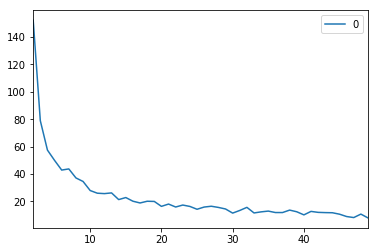

In [10]:
data =  df.iloc[:, 1:].values

ssc = {}
for cluster in range(2, 50):
    obj = KmeansCluster(center=cluster)
    obj.fit(data)
    pred = obj.transform(data)
    ssc.update({cluster:compute_sse(data, pred, obj._gravity)})
pd.DataFrame.from_dict(ssc, orient = 'index').plot()

In [9]:
import matplotlib.pyplot as plt
plt.show()

In [12]:
pipe_kmeans = Pipeline([('selkmeans', SelectItem(features=['sepal length (cm)', 'sepal width (cm)','petal length (cm)','petal width (cm)'])),
              ('keans',  KmeansCluster(center=4))
             ])
pipe_kmeans.fit(df)
pipe_kmeans.transform(df)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 3, 1, 3, 3, 2, 3, 3, 3,
       1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3,
       1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1], dtype=int64)